In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import classification_report, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch


## Reading and Preprocessing Dataset

In [4]:
# Read the dataset
dataPath = 'dataset/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv'
data = pd.read_csv(dataPath)

In [8]:
# Main statistics
print(data.describe())

             value
count  4032.000000
mean     43.110372
std       4.303565
min      34.766000
25%      39.296000
50%      42.918000
75%      46.006000
max      68.092000


In [10]:
# Check for missing values
print(data.isnull().sum())

timestamp    0
value        0
dtype: int64


## Visualizations

In [15]:
palette_color = sns.color_palette('bright') 

### Visualization: 1

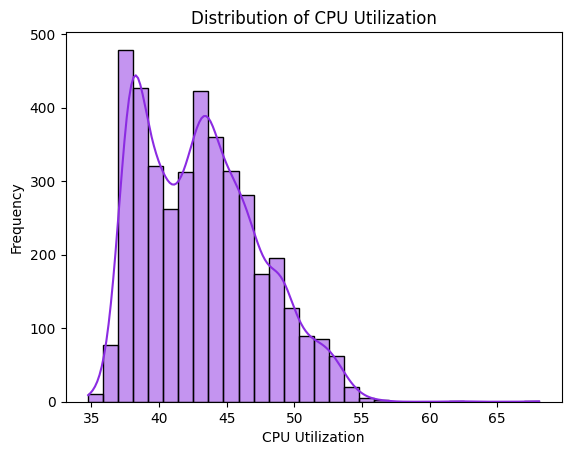

In [50]:
# Histogram of the CPU utilization values
sns.histplot(data['value'], bins=30, kde=True, color=palette_color[4])
plt.title('Distribution of CPU Utilization')
plt.xlabel('CPU Utilization')
plt.ylabel('Frequency')
plt.show()

### Visualization: 2

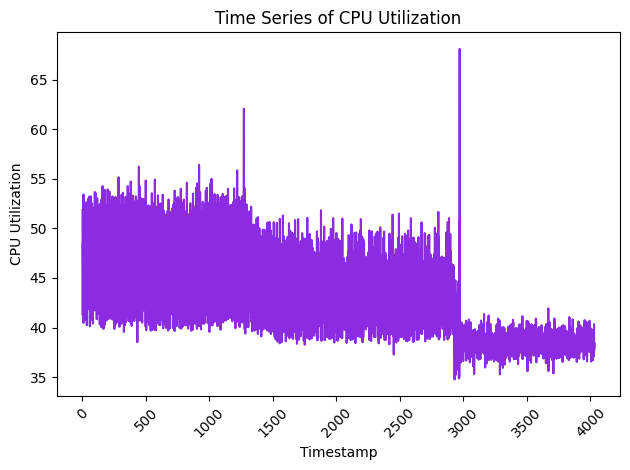

In [51]:
# Time-series plot
plt.plot(data.index, data['value'], color=palette_color[4])
plt.title('Time Series of CPU Utilization')
plt.xlabel('Timestamp')
plt.ylabel('CPU Utilization')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualization: 3

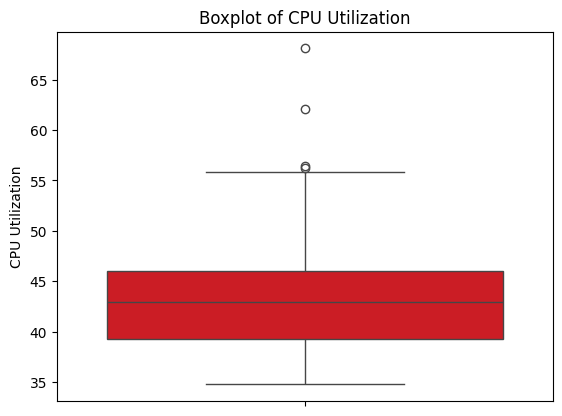

In [52]:
# Boxplot for outliers
sns.boxplot(data=data, y='value', color=palette_color[3])
plt.title('Boxplot of CPU Utilization')
plt.ylabel('CPU Utilization')
plt.show()

In [55]:
# Remove the 'timestamp' column before normalization
data_numeric = data.drop(columns=['timestamp'])

# Normalize the data
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_numeric), columns=data_numeric.columns)


## Data Splitting and Tensoring

In [67]:
# Calculate sizes for each split
total_size = len(data_scaled)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_data = data_scaled[:train_size]
val_data = data_scaled[train_size:train_size+val_size]
test_data = data_scaled[train_size+val_size:]

# Convert to PyTorch tensors
X_train = torch.tensor(train_data.values.astype(np.float32))
X_val = torch.tensor(val_data.values.astype(np.float32))
X_test = torch.tensor(test_data.values.astype(np.float32))

In [65]:
# Check the shape of the datasets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)

Training set shape: torch.Size([2822, 1])
Validation set shape: torch.Size([604, 1])
Testing set shape: torch.Size([606, 1])


In [66]:
# Create PyTorch Dataset objects
train_dataset = TensorDataset(X_train)
val_dataset = TensorDataset(X_val)
test_dataset = TensorDataset(X_test)

# Dataloaders
batch_size = 64  # Define your batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Model 1: Base Autoencoder


In [71]:
class BaseAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(BaseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, encoding_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Model 2: Base Autoencoder and Dense Layers

In [72]:
class DenseAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DenseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, encoding_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Model 3: Base Autoencoder, Dense Layers and tanh Activation Function

In [73]:
class TanhAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(TanhAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, encoding_dim),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Model 4: Base Autoencoder, Dense Layers, tanh Activation Function and Dropout

In [74]:
class DropoutAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DropoutAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Tanh(),
            nn.Dropout(0.2),  # Add dropout layer
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, encoding_dim),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Dropout(0.2),  # Add dropout layer
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [77]:
# # Initialize the model
# input_dim = X_train.shape[1]  # Input dimension
# encoding_dim = 32  # Dimension of the encoded representation
# model = BaseAutoencoder(input_dim, encoding_dim)

In [78]:
# # Define loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [79]:
# Define training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for data in train_loader:
            optimizer.zero_grad()
            inputs = data[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs = data[0]
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item() * inputs.size(0)
            val_loss = val_loss / len(val_loader.dataset)
            val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

In [100]:
def evaluate(model, data_loader):
    model.eval()
    reconstruction_errors = []

    with torch.no_grad():
        for data in data_loader:
            inputs = data[0]
            reconstruction = model(inputs)
            loss = torch.mean((inputs - reconstruction) ** 2, dim=1)  # Mean squared error per sample
            reconstruction_errors.extend(loss.numpy())  # Assuming you're not using GPUs


    # Plotting the reconstruction errors
    plt.hist(reconstruction_errors, bins=50)
    plt.xlabel('Reconstruction error')
    plt.ylabel('Frequency')
    plt.title('Reconstruction error distribution')
    plt.show()

    return reconstruction_errors


In [85]:
# Define function to calculate accuracy
def calculate_accuracy(reconstruction_errors, threshold):
    reconstruction_errors = results[0]['reconstruction_errors']  # Assuming the first model's errors are representative
    threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)  # Set threshold as mean + 2 standard deviations
    predictions = [1 if error > threshold else 0 for error in reconstruction_errors]
    accuracy = sum(predictions) / len(predictions)
    return accuracy

Epoch 1/5, Train Loss: 0.0177, Val Loss: 0.0378
Epoch 2/5, Train Loss: 0.0090, Val Loss: 0.0183
Epoch 3/5, Train Loss: 0.0017, Val Loss: 0.0020
Epoch 4/5, Train Loss: 0.0001, Val Loss: 0.0016
Epoch 5/5, Train Loss: 0.0001, Val Loss: 0.0010


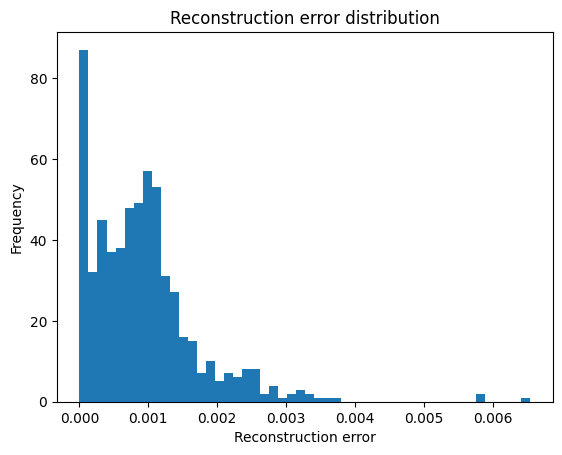


Model: BaseAutoencoder
Final Train Loss: 5.647905255042226e-05
Final Val Loss: 0.001032878400754825
Reconstruction Errors: [6.6045286e-05, 0.00058424566, 9.131847e-05, 0.0009497363, 0.0037806635, 0.00080750295, 0.0007456293, 0.0010124445, 0.0011184026, 0.0004213442, 0.0020300788, 0.0006170843, 2.7617049e-05, 0.0006875123, 5.0899347e-05, 0.00070650387, 0.00027937794, 0.0011735249, 0.0010948936, 0.0011184026, 0.00070650387, 0.00015329069, 0.0013662738, 0.0006875123, 2.5754644e-05, 0.0003436154, 3.9304945e-05, 0.0004898499, 0.00080750295, 0.0008950778, 0.001002172, 0.0009878963, 0.00081112405, 0.0017987618, 0.00065248506, 0.0024065739, 6.7599794e-05, 0.0016515815, 8.189716e-08, 0.0026159831, 0.0006691025, 0.002551762, 0.0009878963, 0.0021227663, 0.00080750295, 0.0004104624, 0.00023457513, 0.00034833304, 0.00024187719, 0.00094181387, 0.00012583408, 0.0015132717, 0.0010995733, 0.0014143363, 0.001358355, 0.0013795332, 0.0012326271, 0.0010764924, 0.0014143363, 0.001902077, 0.00021413995, 0.0

In [102]:
# Train each model
# models = [BaseAutoencoder, DenseAutoencoder, TanhAutoencoder, DropoutAutoencoder]
models = [BaseAutoencoder]

results = []
input_dim = X_train.shape[1]  # Input dimension
encoding_dim = 32  # Dimension of the encoded representation


for model_class in models:
    model = model_class(input_dim, encoding_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)
    reconstruction_errors = evaluate(model, test_loader)

    threshold = np.percentile(reconstruction_errors, 95)
    anomalies = np.array(reconstruction_errors) > threshold
    accuracy = len(anomalies) / len(test_data)


    # Store results
    results.append({
        "model_class": model_class.__name__,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "reconstruction_errors": reconstruction_errors,
        "threshold": threshold,
        "anomalies": anomalies,
        "accuracy": accuracy
    })

# Compare performance
for result in results:
    print(f"\nModel: {result['model_class']}")
    print(f"Final Train Loss: {result['train_losses'][-1]}")
    print(f"Final Val Loss: {result['val_losses'][-1]}")
    print(f"Reconstruction Errors: {result['reconstruction_errors']}")
    print(f"Threshold: {result['threshold']}")
    print(f"Anomalies: {result['anomalies']}")
    print(f"Accuracy: {result['accuracy']}")
